In [53]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
#Read in data
train = pd.read_csv("C:/Users/Aditya/Downloads/house-prices-advanced-regression-techniques1/train.csv", delimiter = ",")
test = pd.read_csv("C:/Users/Aditya/Downloads/house-prices-advanced-regression-techniques1/test.csv", delimiter = ",")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data visualisation
Sale price is described and its relationship with certain numerical variables is explored and established as linear.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

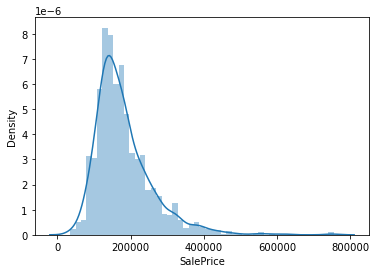

In [38]:
sns.distplot(train['SalePrice'])

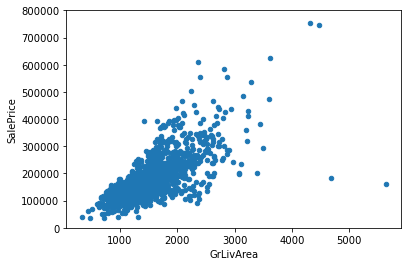

In [39]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

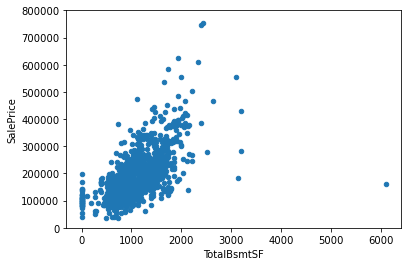

In [40]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

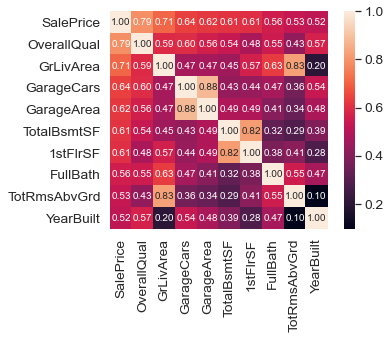

In [63]:
#saleprice correlation matrix
corrmat = train.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Data wrangling

Null values wherever they are above 15% of total data,respective columns are dropped since imputing large data is counter productive and changes nature of given data. Label encoding is also carried out

In [41]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [42]:
#missing data
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_datatest = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_datatest.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [43]:
train = train.drop((missing_data[missing_data['Percent'] > 0.15]).index,1)
test = test.drop((missing_data[missing_data['Percent'] > 0.15]).index,1)

In [44]:
catfeats_fillnamode = \
    ['Electrical', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','Utilities',
     'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish','GarageQual','GarageYrBlt','GarageCond','Functional','KitchenQual']
 
train.loc[:, catfeats_fillnamode] = \
    train[catfeats_fillnamode].fillna(train[catfeats_fillnamode].mode().iloc[0])

train.info()

catfeats_fillnamode1 = \
    ['Electrical','MSZoning', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','Utilities',
     'BsmtFinType1', 'BsmtFinType2', 'GarageType','Exterior1st', 'Exterior2nd', 'GarageFinish','GarageQual','GarageYrBlt','GarageCond','Functional','SaleType','KitchenQual']

test.loc[:, catfeats_fillnamode1] = \
    test[catfeats_fillnamode1].fillna(test[catfeats_fillnamode1].mode().iloc[0])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [45]:
catfeats_fillnamean = \
    ['MasVnrArea']
 
train.loc[:, catfeats_fillnamean] = \
    train[catfeats_fillnamean].fillna(train[catfeats_fillnamean].mean().iloc[0])

catfeats_fillnamean1 = \
    ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF',
     'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars','GarageArea']
test.loc[:, catfeats_fillnamean1] = \
    test[catfeats_fillnamean1].fillna(test[catfeats_fillnamean1].mean().iloc[0])
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [50]:
s = (train.dtypes == 'object')
r = (test.dtypes == 'object')
object_cols = list(s[s].index)
object_cols = list(r[r].index)
label_encoder = LabelEncoder()
for col in object_cols:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])
    
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int32  
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int32  
 5   LotShape       1460 non-null   int32  
 6   LandContour    1460 non-null   int32  
 7   Utilities      1460 non-null   int32  
 8   LotConfig      1460 non-null   int32  
 9   LandSlope      1460 non-null   int32  
 10  Neighborhood   1460 non-null   int32  
 11  Condition1     1460 non-null   int32  
 12  Condition2     1460 non-null   int32  
 13  BldgType       1460 non-null   int32  
 14  HouseStyle     1460 non-null   int32  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

# Building model

In [51]:
X = train.drop(["Id","SalePrice"],axis=1)
Y =  train["SalePrice"] 
X1 = test.drop(["Id"],axis=1)

In [54]:
lr = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
model = lr.fit(X_train, Y_train)
predictions = model.predict(X_test)
print ('RMSE is: \n', mean_squared_error(Y_test, predictions, squared = False))

RMSE is: 
 28377.20071143499


In [55]:
GBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBR.fit(X_train,Y_train)
Pred = GBR.predict(X_test)
print ('RMSE is: \n', mean_squared_error(Y_test, Pred, squared = False))

RMSE is: 
 24960.669751907753


In [56]:
M2model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
M2model_lgb.fit(X_train,Y_train)
Pred2 = M2model_lgb.predict(X_test)
print ('RMSE is: \n', mean_squared_error(Y_test, Pred2, squared = False))

RMSE is: 
 24924.193107162315


In [59]:
M3model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
M3model_xgb.fit(X,Y)
#Pred3 = M3model_xgb.predict(X_test)
#print ('RMSE is: \n', mean_squared_error(Y_test, Pred3, squared = False))

[23:42:20] WARNING: D:\Build\xgboost\xgboost-1.2.1.git\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
Pred3 = M3model_xgb.predict(X1)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':Pred3})
filename = "C:/Users/Aditya/Downloads/house-prices-advanced-regression-techniques1/predictionsXGBR.csv"
submission.to_csv(filename, index = False)